# Understanding Principal Gradients and Diffusion Maps

Things I want to know:
    
- How do the diffusion map gradients compare to standard eigenvectors and LBO?
- Can we do diffusion map gradients on parcellated connectomes?
- What's the deal with the alpha paramater and laplacian / laplace-beltrami / fokker planck ?

## Setup

Importage

In [1]:
# In[109]:


import numpy as np
import scipy as sp
import scipy.io

import nibabel as nib

from nilearn.plotting import plot_surf_stat_map

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import matplotlib.colors as colors


import sys
sys.path.append('/home/hpc3230/Code/libraries_of_others/github/mindboggle')
import mindboggle
from mindboggle.shapes.laplace_beltrami import computeAB
from scipy.sparse.linalg import eigsh

/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/nibabel/cifti2/parse_cifti2.py:24: FutureWarning: We no longer carry a copy of the 'six' package in nibabel; Please import the 'six' package directly
  from ..externals.six import BytesIO
/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### Macaque data

Start with this because it's smaller. 

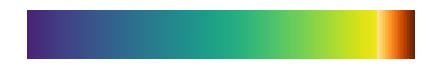

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)



#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = int((128*2)-np.round(255*(1.-0.90)))
second = (256-first)
#colors2 = new_cmap(np.linspace(0, 1, first))
colors2 = plt.cm.viridis(np.linspace(0.1, .98, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.25, 1, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.5, second))
#colors4 = plt.cm.pink(np.linspace(0.9, 1., second))
# combine them and build a new colormap
cols = np.vstack((colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))
    

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

In [3]:
def getIds(mat_name, names):
    
    lex = pd.read_csv('gradient_data/macaque/ids_areas.txt', ' ', header=-1)[1]

    ids = np.zeros(len(names))
    for i,y in enumerate(names):
        for n,x in enumerate(lex):
            if x == y:
                ids[i] = n
    return ids

def project_to_surface(mat_name, names, emb_comp):
    
    idx = getIds(mat_name, names)
    comp = emb_comp
    data = np.zeros(len(vertices))
    for n, x in enumerate(idx):
        if x != 0:
            data[np.where(nodes[atlases.get(mat_name)] == x)] = comp[n]
    data = np.squeeze(data)
    
    return data

def visualize_macaque(mat_name, comp, reverse=False,cmap=mymap,symmetric_cbar=True,vmax=None):
    
    emb = np.load('gradient_data/conn_matrices/macaque_%s_emb.npy' % mat_name)
    names = np.load('gradient_data/conn_matrices/macaque_%s_names.npy' % mat_name)
    
    if reverse==True:
        
        emb[:,comp] = emb[:,comp] * -1
        
    data = project_to_surface(mat_name, names, emb[:,comp] - np.mean(emb[:,comp]))
    print np.max(data)
    print np.min(data)
    
    if vmax == None: vmax = np.max(data)
    

    
    latsurf = plot_surf_stat_map([vertices,triangles],data, bg_map=sulc,
                                 hemi='right', view='lateral', threshold=None,
                     alpha='auto', vmax=vmax, cmap=cmap,
                     symmetric_cbar=False, bg_on_data=True, darkness=1,
                     title=None, output_file=None)       
    
    medsurf = plot_surf_stat_map([vertices,triangles],data, bg_map=sulc,
                    hemi='right', view='medial', threshold=None,
                     alpha='auto', vmax=vmax, cmap=cmap,
                     symmetric_cbar=False, bg_on_data=True, darkness=1,
                     title=None, output_file=None)       
    
    return latsurf,medsurf,data



def visualize_macaque_bb47(datvec, reverse=False,cmap=mymap,symmetric_cbar=True,vmax=None):
    
    #emb = np.load('gradient_data/conn_matrices/macaque_%s_emb.npy' % mat_name)
    names = np.load('gradient_data/conn_matrices/macaque_bb47_names.npy')
    
    if len(datvec) != vertices.shape[0]:
        datvec = project_to_surface('bb47', names, datvec)# ,emb[:,comp] - np.mean(emb[:,comp]))
        #print np.max(data)
        #print np.min(data)
    
    
    if vmax == None: vmax = np.max(datvec)
    
    latsurf = plot_surf_stat_map([vertices,triangles],datvec, bg_map=sulc,hemi='right', 
                                 view='lateral', threshold=None, alpha='auto', vmax=vmax,
                                 cmap=cmap,symmetric_cbar=symmetric_cbar, bg_on_data=True, darkness=1,
                     title=None, output_file=None)       
    #latsurf = plot_surf_stat_map([vertices, triangles], bg_map=sulc, stat_map=datvec, mask=np.where(nodes[0] != 0.)[0], 
    #                   bg_on_stat=True, azim=10, elev=20, label=True, lenient=True, vmax=np.max(datvec), 
    #                   cmap=mymap, symmetric_cbar=False);
    #fname = 'gradient_data/figures/fig.macaque.%s.%s.lat.png' % (mat_name, comp)
    #f.savefig(fname, format='png', dpi=600, transparent=False)
    #imageCrop(fname)
    #plt.show()
    
    medsurf = plot_surf_stat_map([vertices,triangles],datvec, bg_map=sulc,
                                  hemi='right', view='medial', threshold=None,
                                  alpha='auto', vmax=vmax, cmap=cmap,
                                  symmetric_cbar=symmetric_cbar, bg_on_data=True, darkness=1,
                                  title=None, output_file=None)       

    #medsurf = plot_surf_stat_map([vertices, triangles], bg_map=sulc, stat_map=datvec, mask=np.where(nodes[0] != 0.)[0], 
    #                   bg_on_stat=True, azim=180, elev=20, label=True, lenient=True, vmax=np.max(datvec),
    #                   cmap=mymap, symmetric_cbar=False)
    #fname = 'gradient_data/figures/fig.macaque.%s.%s.med.png' % (mat_name, comp)
    #f.savefig(fname, format='png', dpi=600, transparent=False)
    #imageCrop(fname)    
    #plt       show()
    return latsurf,medsurf,datvec

In [4]:


def visualize_surf_data(datvec, vertices=None,triangles=None,reverse=False,cmap=mymap,symmetric_cbar=True,
                        vmax=None,bg_map=None,hemi=None):
    
    """
    #emb = np.load('gradient_data/conn_matrices/macaque_%s_emb.npy' % mat_name)
    names = np.load('gradient_data/conn_matrices/macaque_bb47_names.npy')
    
    if len(datvec) != vertices.shape[0]:
        datvec = project_to_surface('bb47', names, datvec)# ,emb[:,comp] - np.mean(emb[:,comp]))
        #print np.max(data)
        #print np.min(data)
    
    """;
    
    if vmax == None: vmax = np.max(datvec)
    
    latsurf = plot_surf_stat_map([vertices,triangles],datvec, bg_map=bg_map,hemi=hemi, 
                                 view='lateral', threshold=None, alpha='auto', vmax=vmax,
                                 cmap=cmap,symmetric_cbar=symmetric_cbar, bg_on_data=True, darkness=1,
                     title=None, output_file=None)       
    #latsurf = plot_surf_stat_map([vertices, triangles], bg_map=sulc, stat_map=datvec, mask=np.where(nodes[0] != 0.)[0], 
    #                   bg_on_stat=True, azim=10, elev=20, label=True, lenient=True, vmax=np.max(datvec), 
    #                   cmap=mymap, symmetric_cbar=False);
    #fname = 'gradient_data/figures/fig.macaque.%s.%s.lat.png' % (mat_name, comp)
    #f.savefig(fname, format='png', dpi=600, transparent=False)
    #imageCrop(fname)
    #plt.show()
    
    medsurf = plot_surf_stat_map([vertices,triangles],datvec, bg_map=bg_map,
                                  hemi=hemi, view='medial', threshold=None,
                                  alpha='auto', vmax=vmax, cmap=cmap,
                                  symmetric_cbar=symmetric_cbar, bg_on_data=True, darkness=1,
                                  title=None, output_file=None)       

    #medsurf = plot_surf_stat_map([vertices, triangles], bg_map=sulc, stat_map=datvec, mask=np.where(nodes[0] != 0.)[0], 
    #                   bg_on_stat=True, azim=180, elev=20, label=True, lenient=True, vmax=np.max(datvec),
    #                   cmap=mymap, symmetric_cbar=False)
    #fname = 'gradient_data/figures/fig.macaque.%s.%s.med.png' % (mat_name, comp)
    #f.savefig(fname, format='png', dpi=600, transparent=False)
    #imageCrop(fname)    
    #plt       show()
    return latsurf,medsurf,datvec

In [18]:
# Region names
f = 'gradient_data/conn_matrices/macaque_bb47_names.npy'
bb47_names = np.load(f)


# Load surfaces

mat = sp.io.loadmat('gradient_data/macaque/f99_vertices_faces.mat')
vertices = np.array(mat['vertices'], dtype=np.float64)
triangles = np.array(mat['faces'] - 1, dtype=np.int32)
# sulc = np.array(pd.read_csv('gradient_data/macaque/surf.sulc.asc', ' ', header=-1)[4]) * -1.
# nib.freesurfer.write_geometry('gradient_data/macaque/rh.pial', vertices, triangles)
# ! mris_inflate -sulc sulc -n 15 rh.pial inflated
sulc = nib.freesurfer.read_morph_data('gradient_data/macaque/rh.sulc') * -1
nodes = pd.read_csv('gradient_data/macaque/nodes_areaids.txt', '\t', header=-1)

atlases = {'rm': 0, 'lv': 1, 'fv': 3, 'b05': 4, 'bb47': 5, 'pht00': 7}

bb47_nodes = nodes[atlases['bb47']]

bb47_idx = getIds('bb47', bb47_names)
#np.where(nodes[atlases.get('bb47')] == n)[0]

"""
regmap_1 = np.zeros_like(vertices[:,0])
regmap_2 = np.zeros_like(vertices[:,0])


for i_it,i in enumerate(bb47_idx):
    theseidxs = np.where(nodes[atlases.get('bb47')] == i)[0]
    regmap_1[theseidxs] = i_it
    regmap_2[theseidxs] = i
""";

Figures from notebooks

1.14777518875
-1.84654885002


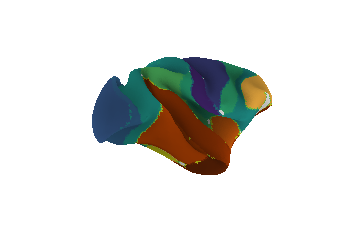

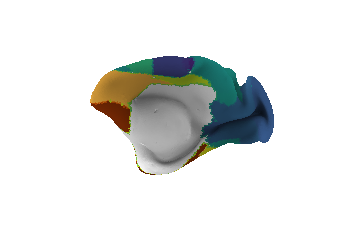

In [178]:
# In[112]:


latsurf,medsurf,vecdat = visualize_macaque('bb47', 0, reverse=False,symmetric_cbar=False);


# In[ ]:

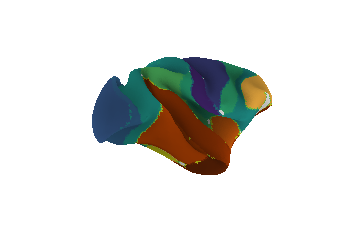

In [179]:
latsurf

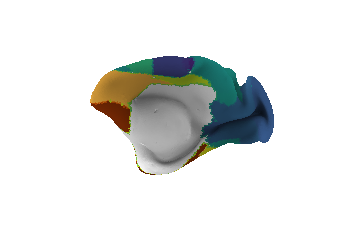

In [212]:
medsurf

Alternative version

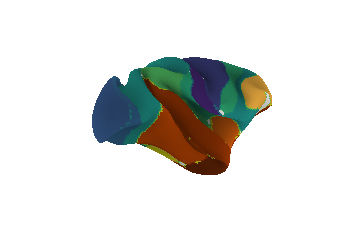

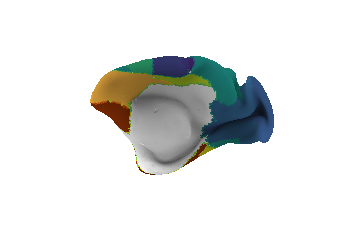

In [23]:
bb47_emb = np.load('gradient_data/conn_matrices/macaque_bb47_emb.npy')  
latsurf,medsurf,datvec = visualize_macaque_bb47(bb47_emb[:,0],symmetric_cbar=False)

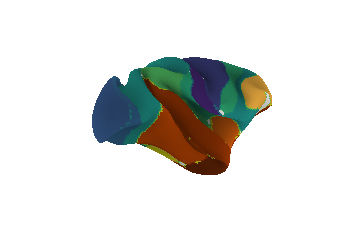

In [214]:
latsurf

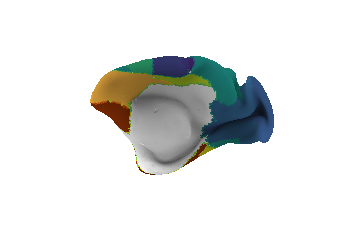

In [215]:
medsurf

Different colour scheme

In [27]:
bb47_emb = np.load('gradient_data/conn_matrices/macaque_bb47_emb.npy')  

In [216]:
bb47_emb = np.load('gradient_data/conn_matrices/macaque_bb47_emb.npy')  
cmap='coolwarm'
latsurf,medsurf,datvec = visualize_macaque_bb47(bb47_emb[:,0],cmap=cmap,symmetric_cbar=True)

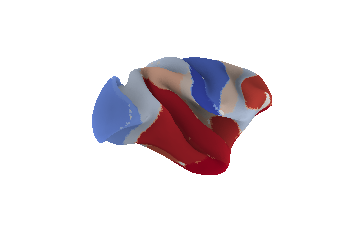

In [217]:
latsurf

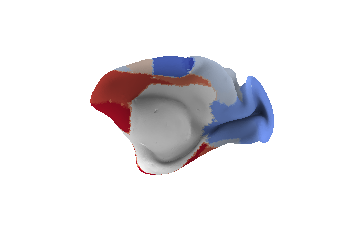

In [218]:
medsurf

In [237]:
cmap='coolwarm'
latsurf,medsurf,datvec = visualize_macaque_bb47(bb47_emb[:,1],cmap=cmap,symmetric_cbar=True)

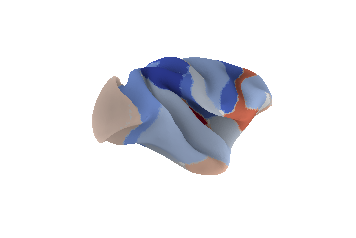

In [238]:
latsurf

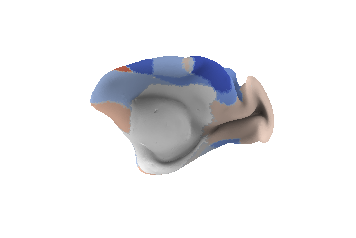

In [239]:
medsurf

Diffusion operator eienvectors vs. connectivity matrix eigenvectors

In [20]:
bb47_conn = np.load('gradient_data/conn_matrices/macaque_bb47_conn.npy')

In [21]:
bb47_conn_evals,bb47_conn_evecs = np.linalg.eig(bb47_conn)

In [231]:
cmap='coolwarm'
latsurf,medsurf,datvec = visualize_macaque_bb47(bb47_conn_evecs[:,1],cmap=cmap,symmetric_cbar=True)

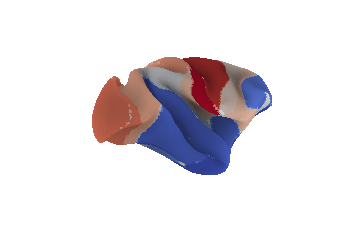

In [232]:
latsurf

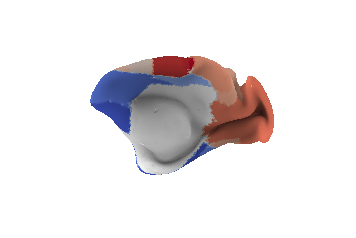

In [233]:
medsurf

In [234]:
cmap='coolwarm'
latsurf,medsurf,datvec = visualize_macaque_bb47(bb47_conn_evecs[:,2],cmap=cmap,symmetric_cbar=True)

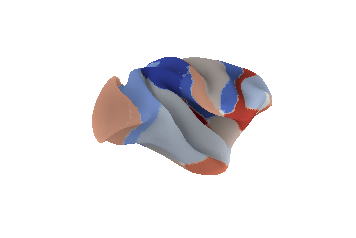

In [235]:
latsurf

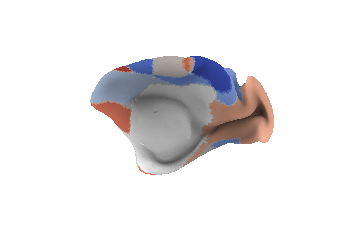

In [236]:
medsurf

Connectivity matrix eigenvectors and diffusion maps are basically identical!

In [242]:
np.corrcoef(bb47_conn_evecs[:,1],bb47_emb[:,0])

array([[ 1.        , -0.99025373],
       [-0.99025373,  1.        ]])

In [243]:
np.corrcoef(bb47_conn_evecs[:,2],bb47_emb[:,1])

array([[ 1.        ,  0.96574917],
       [ 0.96574917,  1.        ]])

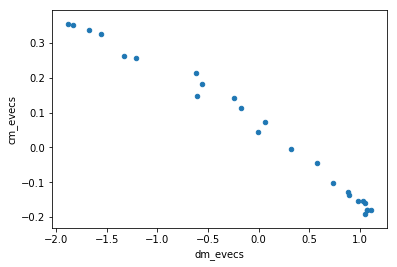

In [268]:
pd.DataFrame([bb47_emb[:,0],bb47_conn_evecs[:,1]],index=['dm_evecs', 'cm_evecs']).T.plot(kind='scatter',
                                                                                         x='dm_evecs',
                                                                                         y='cm_evecs')

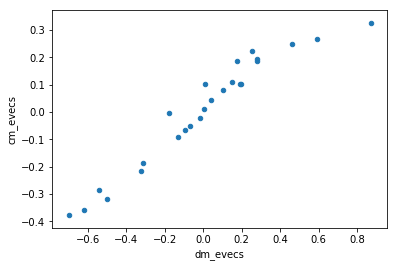

In [265]:
pd.DataFrame([bb47_emb[:,1],bb47_conn_evecs[:,2]],index=['dm_evecs', 'cm_evecs']).T.plot(kind='scatter',
                                                                                         x='dm_evecs',
                                                                                         y='cm_evecs')

In [33]:
bb47_emb[bb47_nodes,:]

IndexError: index 265 is out of bounds for axis 0 with size 25

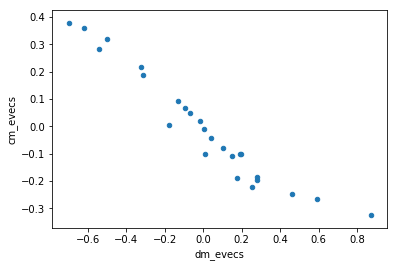

In [24]:
pd.DataFrame([bb47_emb[:,1],bb47_conn_evecs[:,2]],index=['dm_evecs', 'cm_evecs']).T.plot(kind='scatter',
                                                                                         x='dm_evecs',
                                                                                         y='cm_evecs')

In [ ]:
pd.DataFrame([bb47_emb[:,1],bb47_conn_evecs[:,2]],index=['dm_evecs', 'cm_evecs']).T.plot(kind='scatter',
                                                                                         x='dm_evecs',
                                                                                         y='cm_evecs')

In [39]:
bb47_names

array(['BoninBailey.FA', 'BoninBailey.FB', 'BoninBailey.FC',
       'BoninBailey.FF', 'BoninBailey.FL', 'BoninBailey.IA',
       'BoninBailey.IB', 'BoninBailey.LA', 'BoninBailey.LC',
       'BoninBailey.PE', 'BoninBailey.OA', 'BoninBailey.OB',
       'BoninBailey.OC', 'BoninBailey.PA', 'BoninBailey.PB',
       'BoninBailey.PC', 'BoninBailey.PF', 'BoninBailey.PG',
       'BoninBailey.TA', 'BoninBailey.TB', 'BoninBailey.TC',
       'BoninBailey.TE', 'BoninBailey.TF', 'BoninBailey.TG',
       'BoninBailey.TH'], dtype=object)

In [65]:
data1 = project_to_surface('bb47', bb47_names, bb47_emb[:,1])
data2 = project_to_surface('bb47', bb47_names, bb47_conn_evecs[:,2])
data3 = bb47_lbo_evecs[:,3]

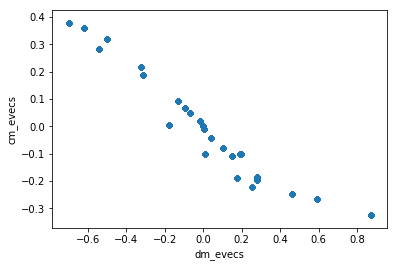

In [50]:
pd.DataFrame([data1,data2],index=['dm_evecs', 'cm_evecs']).T.plot(kind='scatter',
                                                                  x='dm_evecs',
                                                                  y='cm_evecs')

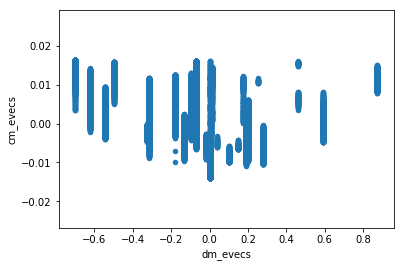

In [66]:
pd.DataFrame([data1,data3],index=['dm_evecs', 'cm_evecs']).T.plot(kind='scatter',
                                                                  x='dm_evecs',
                                                                  y='cm_evecs')

Show connectivity eigenvectors with mymap scaling

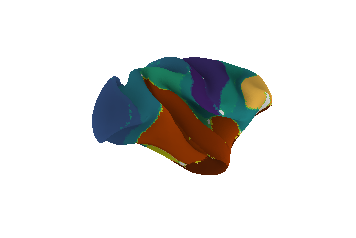

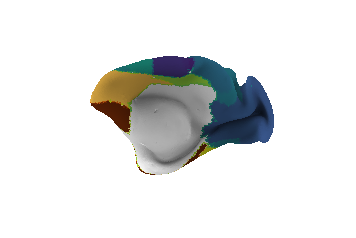

In [277]:
latsurf,medsurf,datvec = visualize_macaque_bb47(bb47_conn_evecs[:,1]*-1,cmap=mymap,symmetric_cbar=False,
                                                vmax=0.17);

LBO mode decomposition of monkey cortex

In [6]:
from scipy.sparse.linalg import eigs

from nilearn.plotting import plot_surf

In [7]:
bb47_A,bb47_B = computeAB(vertices,triangles)

In [10]:
bb47_A_mod = bb47_A.copy()

In [11]:
c = 1E-20
for a in range(bb47_A_mod.shape[0]): bb47_A_mod[a,a] += c

/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [12]:
bb47_lbo_evals,bb47_lbo_evecs = eigsh(bb47_A_mod,M=bb47_B,sigma=0,k=10)

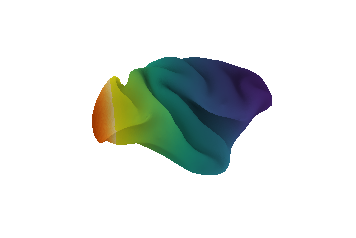

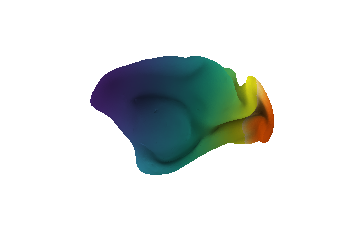

In [13]:
datvec = bb47_lbo_evecs[:,1].astype(float)#*-1

latsurf,medsurf,datvec = visualize_macaque_bb47(datvec,cmap=mymap,symmetric_cbar=False,vmax=0.015)

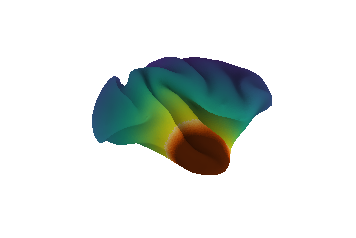

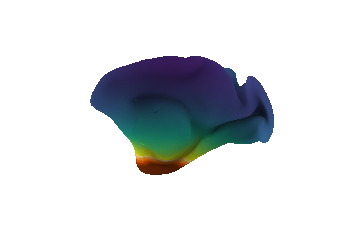

In [14]:
datvec = bb47_lbo_evecs[:,2].astype(float)#*-1

latsurf,medsurf,datvec = visualize_macaque_bb47(datvec,cmap=mymap,symmetric_cbar=False,vmax=0.015)

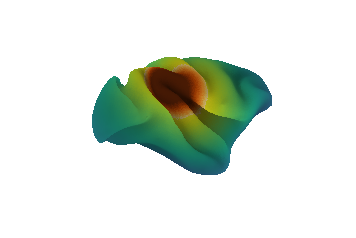

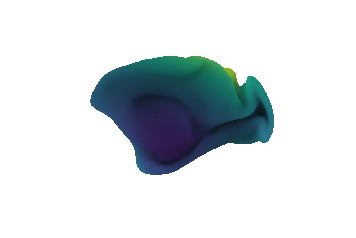

In [15]:
datvec = bb47_lbo_evecs[:,3].astype(float)#*-1

latsurf,medsurf,datvec = visualize_macaque_bb47(datvec,cmap=mymap,symmetric_cbar=False,vmax=0.015)

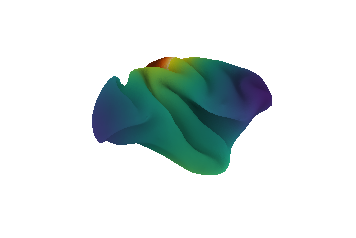

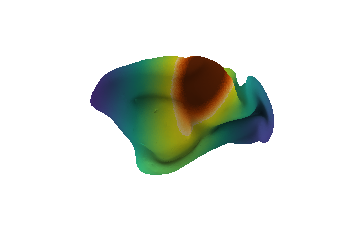

In [16]:
datvec = bb47_lbo_evecs[:,4].astype(float)#*-1

latsurf,medsurf,datvec = visualize_macaque_bb47(datvec,cmap=mymap,symmetric_cbar=False,vmax=0.015)

## Freesurfer data

Just want to look at fsaverage surfaces with that colour scale

In [7]:
import nibabel as nib

In [8]:
import os

In [23]:
f = '/opt/freesurfer/freesurfer/subjects/fsaverage5/surf/lh.curv'
lhc_dat = nib.freesurfer.read_morph_data(f)

In [18]:
f = '/opt/freesurfer/freesurfer/subjects/fsaverage5/surf/lh.pial'

In [19]:
lhp_vtx,lhp_tri = nib.freesurfer.read_geometry(f)

In [44]:

#lhp_lbo_A,lhp_lbo_B = computeAB(lhp_vtx,lhp_tri)

#lhp_lbo_evals,lhp_lbo_evecs = eigsh(lhp_lbo_A,M=lhp_lbo_B)

In [45]:
lhp_lbo_A, lhp_lbo_B = computeAB(lhp_vtx,lhp_tri)
lhp_lbo_A_evals,lhp_lbo_A_evecs = eigsh(lhp_lbo_A,k=30,M=lhp_lbo_B,sigma=0)

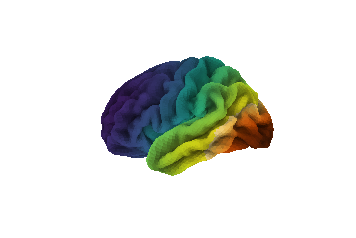

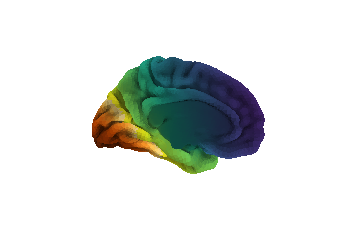

In [47]:
datvec = lhp_lbo_A_evecs[:,1].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

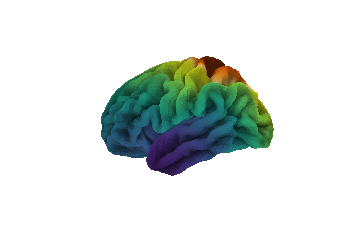

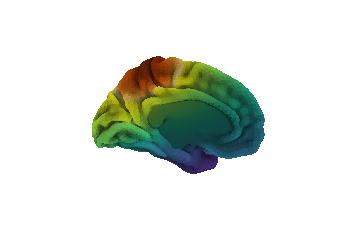

In [48]:
datvec = lhp_lbo_A_evecs[:,2].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

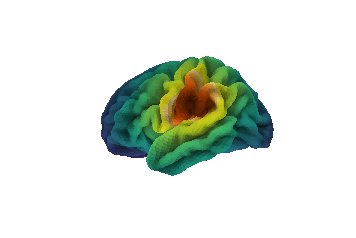

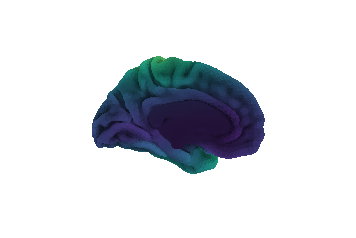

In [49]:
datvec = lhp_lbo_A_evecs[:,3].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

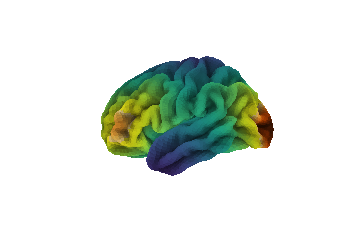

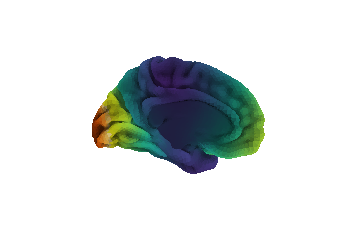

In [50]:
datvec = lhp_lbo_A_evecs[:,4].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

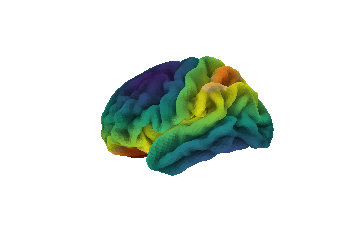

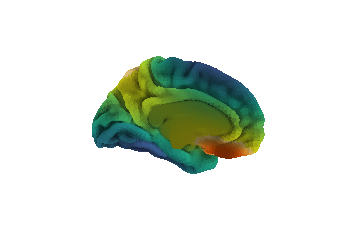

In [51]:
datvec = lhp_lbo_A_evecs[:,5].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

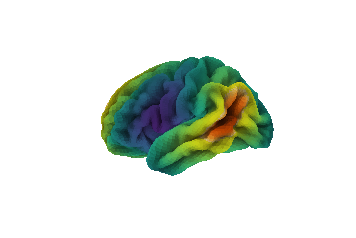

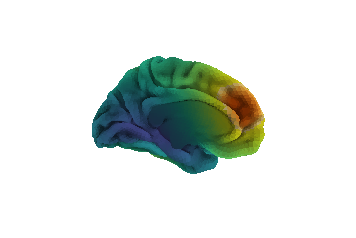

In [52]:
datvec = lhp_lbo_A_evecs[:,6].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

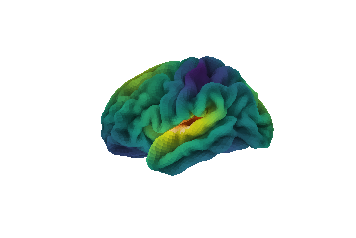

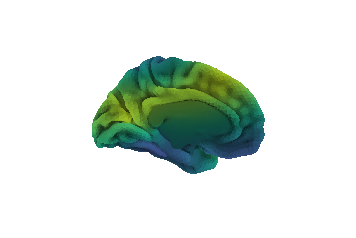

In [73]:
datvec = lhp_lbo_A_evecs[:,7].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

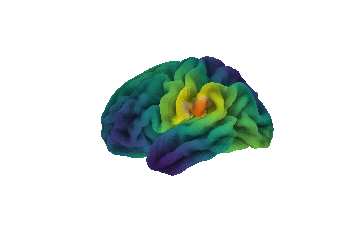

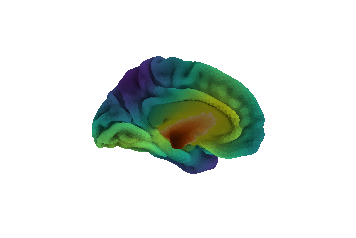

In [72]:
datvec = lhp_lbo_A_evecs[:,8].astype(float)
visualize_surf_data(datvec, vertices=lhp_vtx,triangles=lhp_tri,reverse=False,cmap=mymap,symmetric_cbar=False,
                        vmax=None,bg_map=lhc_dat,hemi='left');

### HCP data

Now look at same thing with HCP data...

In [ ]:
ver

In [278]:
# Save affinity matrix
f = 'gradient_data/conn_matrices/cosine_affinity.npy'
hcp_aff = np.load(f)

In [279]:
hcp_aff.shape

(91282, 91282)

In [ ]:
from scipy.sparse.linalg import eigsh

## Graveyard`

In [2]:
import cfflib

/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/nibabel/cifti2/parse_cifti2.py:24: FutureWarning: We no longer carry a copy of the 'six' package in nibabel; Please import the 'six' package directly
  from ..externals.six import BytesIO


In [56]:
mmcff = cfflib.load('/scratch/hpc3230/Data/cmtk_data/macaca_mulatta_01.cff')

lh_surf,rm = mmcff.get_connectome_surface()



lh_surf.load()
lh_vtx = lh_surf.data.darrays[0].data
lh_tri = lh_surf.data.darrays[1].data

from nilearn.plotting import plot_surf

%matplotlib inline

lh_vtx.shape

Loading file. Created temporary file: /tmp/macaque_connectivity_right_hemisphere978208/Gifti/macaca01.gii
Succeed.


(30736, 3)

In [52]:
lh_tri.max
 

()

30735

In [29]:
tri.max()

plot_surf([vtx,tri])

30735

In [ ]:
import sys
sys.path.append('~/Code/libraries_of_others/github/mindboggle')
from mindboggle.shapes.laplace_beltrami import computeAB

In [57]:
f = '/scratch/hpc3230/Data/from_gleb/f99_vertices_faces.mat'

In [58]:
import h5py

In [59]:
from scipy.io import loadmat

In [60]:
F =loadmat(f,struct_as_record=False,squeeze_me=True)

In [64]:
F.keys()

['vertices_sphere',
 '__header__',
 '__globals__',
 'vertices_inflated',
 'vertices_original',
 'faces',
 'vertices_flat',
 'vertices_veryInflated',
 '__version__']

In [ ]:
F['vertices_flat']

In [107]:
vtx =F['vertices_original']
tri =F['faces']
tri-=1

In [85]:
tri.max()

65535

In [86]:
tri.min()

0

In [106]:
vtx.shape

(35946, 3)

In [121]:
tri_rh_idx = (tri >= 35945).sum(axis=1).astype(bool)

In [123]:
tri_rh_idx.shape

(69056,)

In [124]:
vtx.shape

(35946, 3)

In [108]:
keepers = (tri<=35945).sum(axis=1)

In [109]:
tri_k = tri[keepers,:]

In [110]:
tri_k.min()

0

In [112]:
tri_k.max()

65535

ValueError: triangles max element is out of bounds

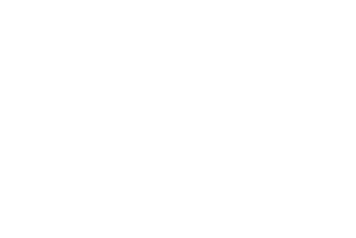

In [111]:
plot_surf([vtx,tri_k])

In [102]:
vtx.shape

(35946, 3)

In [101]:
tri_k.max()

65535

In [ ]:
mmcff = cfflib.load('/scratch/hpc3230/Data/
                    
                    cmtk_data/macaca_mulatta_01.cff')

lh_surf,rm = mmcff.get_connectome_surface()



lh_surf.load()
lh_vtx = lh_surf.data.darrays[0].data
lh_tri = lh_surf.data.darrays[1].data

from nilearn.plotting import plot_surf

%matplotlib inline

lh_vtx.shape

In [125]:
ls /scratch/hpc3230/Data/from_gleb/

01_bb47_matrix.txt   09_ud86_matrix.txt
02_b05_matrix.txt    20160419_f99ParcelsMapping.rar
03_ferry_matrix.txt  CaretSemiCoco_MAP_CORRECTED_sorted.xls
04_fv91_matrix.txt   f99_vertices_faces.mat
05_lv00_matrix.txt   ids_areas.txt
06_pg91_matrix.txt   nodes_areaids.txt
07_pht00_matrix.txt  README_nodes_areaids_columns.txt
08_rm_matrix.txt


In [126]:
ls

01_create_human_connectome.ipynb
01_create_macaque_connectome.ipynb
02_embed_connectomes.ipynb
03_visualize_embeddings.ipynb
04_visualize_distance.ipynb
04_visualize_networks.ipynb
05_metaanalysis_brainmap.ipynb
05_metaanalysis_neurosynth.ipynb
06_supplementary_analysis_and_figures.ipynb
gradient_data/
gradients_in_other_data.ipynb
jg_01_create_human_connectome_jobfile.sh
jg_01_create_human_connectome_jobfile.sh.e2570879
jg_01_create_human_connectome_jobfile.sh.e2754566
jg_01_create_human_connectome_jobfile.sh.o2570879
jg_01_create_human_connectome_jobfile.sh.o2754566
jg_01_create_human_connectome_nb.ipynb
jg_01_create_human_connectome.py
jg_01_create_macaque_connectome_jobfile.sh
jg_01_create_macaque_connectome_jobfile.sh.e2571224
jg_01_create_macaque_connectome_jobfile.sh.o2571224
jg_01_create_macaque_connectome_nb.ipynb
jg_01_create_macaque_connectome.py
jg_02_embed_connectomes_jobfile.sh
jg_02_embed_connectomes_jobfile.sh.e2578389
jg_02_embed_connectomes_jobfile.sh.o2578389
jg_02_e

Gleb data

In [129]:
import numpy as np

In [130]:
cd /scratch/hpc3230/Data/from_gleb/macaque_brain_conmat_viz/

/scratch/hpc3230/Data/from_gleb/macaque_brain_conmat_viz


In [131]:
vtx_noinfl_lh = np.loadtxt('coord_left_noninflated.txt')[:,1:] 
vtx_infl_lh = np.loadtxt('coord_left_inflated.txt')[:,1:]
tri_lh = np.loadtxt('tiles_left.txt').astype(int)

vtx_noinfl_rh = np.loadtxt('coord_right_noninflated.txt')[:,1:] 
vtx_infl_rh = np.loadtxt('coord_right_inflated.txt')[:,1:]
tri_rh = np.loadtxt('tiles_right.txt').astype(int)

rm_lh = np.loadtxt('fv91_vertexMap_left.txt')
rm_rh = np.loadtxt('fv91_vertexMap_right.txt')


weights = np.loadtxt('weights.txt')

lengths = np.loadtxt('tract_lengths.txt')

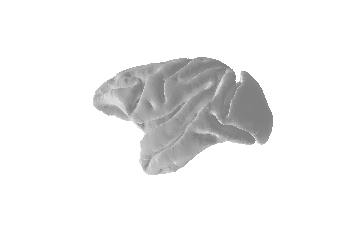

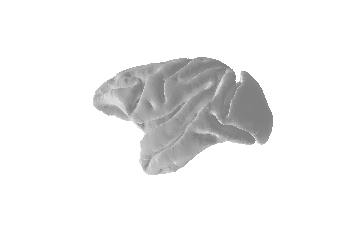

In [132]:
plot_surf([vtx_noinfl_lh,tri_lh])

In [135]:
import sys
sys.path.append('/home/hpc3230/Code/libraries_of_others/github/mindboggle')

In [145]:
from mindboggle.shapes.laplace_beltrami import computeAB,fem_laplacian

In [156]:
from scipy.sparse.linalg import lobpcg

In [157]:
spectrum_size=10

#from scipy.sparse import lobpc


    
# Initial eigenvector values:
init_eigenvecs = np.random.random((A.shape[0], spectrum_size))


# maxiter = 40 forces lobpcg to use 20 iterations.


# Strangely, largest=false finds largest eigenvalues

# and largest=True gives the smallest eigenvalues:

eigenvalues, eigenvectors = lobpcg(A, init_eigenvecs, B=B,
                                   largest=True, maxiter=40)



# Extract the real parts:
    
    

spectrum = [value.real for value in eigenvalues]


# For some reason, the eigenvalues from lobpcg are not sorted:
    

spectrum.sort()

can't get lbo on this macaque brain either...

---

does diffusion map embedding of tvb connectome return default mode network principal modes like it appears to do with macaque?

In [76]:
# put some system-specific variables in the namespace ('le' dict)
%run ~/set_localenv_vars.py

#nb_name = 'parket_et_al_notes'

#repo_dir = le['code_dir'] + '/libraries_of_mine/github/BroadcastingPatternedStimulationAcrossTheConnectome'
#code_dir = repo_dir + '/code'
#data_dir = repo_dir + '/data'

#outdir = data_dir + '/park_et_al_notes'
#import os
#if not os.path.isdir(outdir): os.makedirs(outdir)

In [77]:
# root path to tvb-library, tvb-data, etc. libraries. 
tvb_folder = le['code_dir'] + '/libraries_of_others/github'
tvb_dat_dir = tvb_folder + '/tvb-data'

In [78]:
# Generic imports

import os,sys,glob
from copy import copy
import pandas as pd
import numpy as np
from numpy import (sin,cos,pi,sqrt,r_,round,arange,zeros,tile,nonzero,
                   arange,pi,sin,cos,exp,sqrt,array,zeros,zeros_like,
                   ones,ones_like,floor)
from numpy.random import rand

from scipy.special import erf
from scipy.signal import periodogram


# Visualization stuff

%matplotlib inline
from matplotlib import cm,gridspec,pyplot as plt
import seaborn as sns

# TVB stuff

nbso,nbse = sys.stdout,sys.stderr # hack part 1/2 to keep output printing properly
sys.path.append(tvb_folder +'/tvb-library')
sys.path.append(tvb_folder + '/tvb-data')
from tvb.simulator.lab import *
sys.stdout,sys.stderr = nbso,nbse  # ...hack part 2/2


In [93]:
tvbdef_conn = connectivity.Connectivity(load_default=True)
tvbdef_conn.configure()

tvbdef_weights = tvbdef_conn.weights.copy()

tvbdef_delays = tvbdef_conn.delays.copy()
tvbdef_delays_mean_uniform = np.ones_like(tvbdef_delays) * tvbdef_delays.mean()
tvbdef_delays_200ms = tvbdef_delays*10
tvbdef_delays_200ms_uniform = np.ones_like(tvbdef_delays)*200


tvbdef_weights = tvbdef_conn.weights.copy()
tvbdef_delays_100ms_uniform = np.ones_like(tvbdef_delays)*100
tvbdef_delays_50ms_uniform = np.ones_like(tvbdef_delays)*50

tvbdef_delays_200ms = tvbdef_delays*10
tvbdef_delays_100ms = tvbdef_delays*5
tvbdef_delays_50ms = tvbdef_delays*2.5

In [94]:
tvbdef_weights_evals,tvbdef_weights_evecs = np.linalg.eig(tvbdef_weights)

In [83]:
import sys
sys.path.append('/home/hpc3230/Code/libraries_of_others/github/mapalign')

In [84]:
#import sys
#sys.path.append("../topography/utils_py/mapalign")
from mapalign import embed

In [85]:
tvbdef_weights_emb, tvbdef_weights_res = embed.compute_diffusion_map(tvbdef_weights, alpha = 0.5)

ValueError: Graph is disconnected

In [95]:
zero_rows = np.nonzero(tvbdef_weights.sum(axis=1) == 0)[0]
zero_rows

array([37, 75])

In [96]:

tvbdef_weights_mod = tvbdef_weights.copy()

tvbdef_weights_mod[37,32] = 1.
tvbdef_weights_mod[32,37] = 1.

tvbdef_weights_mod[75,70] = 1.
tvbdef_weights_mod[70,75] = 1.


In [98]:
tvbdef_weights_mod_emb, tvbdef_weights_mod_res = embed.compute_diffusion_map(tvbdef_weights_mod, alpha = 0.5,return_result=True)

In [145]:
tvbdef_weights_mod_evals, tvbdef_weights_mod_evecs = np.linalg.eig(tvbdef_weights_mod)

In [99]:
tvbdef_weights_mod_emb.shape

(76, 2)

In [100]:
tvb_dat_dir

'/home/hpc3230/Code/libraries_of_others/github/tvb-data'

In [244]:
tvb_ctx_file = tvb_dat_dir + '/tvb_data/surfaceData/cortex_16384.zip'
tvb_rm_file = tvb_dat_dir  + '/tvb_data/regionMapping/regionMapping_16k_76.bz2'
tvb_conn_file = tvb_dat_dir + '/tvb_data/connectivity/connectivity_76.zip'

In [245]:
tvb_ctx = cortex.Cortex.from_file(source_file = tvb_ctx_file,
                             region_mapping_file =tvb_rm_file)
tvb_vtx,tvb_tri,tvb_rm = tvb_ctx.vertices,tvb_ctx.triangles,tvb_ctx.region_mapping
tvb_conn = connectivity.Connectivity.from_file(tvb_conn_file); tvb_conn.configure()
isrh_reg = tvb_conn.is_right_hemisphere(range(tvb_conn.number_of_regions))
isrh_vtx = np.array([isrh_reg[r] for r in tvb_rm])

In [108]:
np.nonzero(tvb_conn.weights.sum(axis=1)==0)

(array([37, 75]),)

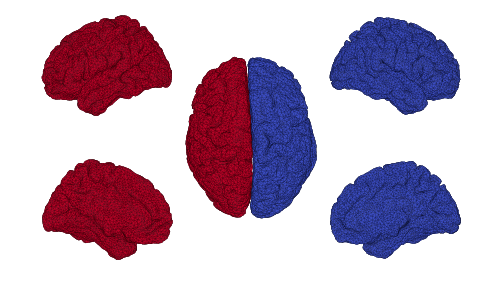

In [137]:
datvec = tvbdef_weights_mod_emb[:,0].astype(float)[tvb_rm]
plot_surface_mpl_mv(vtx=tvb_vtx,tri=tvb_tri,rm=tvb_rm,data=datvec,
                    hemi = isrh_vtx,
                    shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': -0.5, 'vmax': 0.5})

the 2nd eigenvector corresponds to the first embedding vector

/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


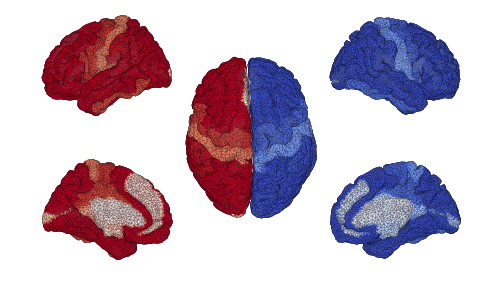

In [146]:
datvec = tvbdef_weights_mod_evecs[:,1].astype(float)[tvb_rm]
plot_surface_mpl_mv(vtx=tvb_vtx,tri=tvb_tri,rm=tvb_rm,data=datvec,
                    hemi = isrh_vtx,
                    shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': -0.1, 'vmax': 0.1})

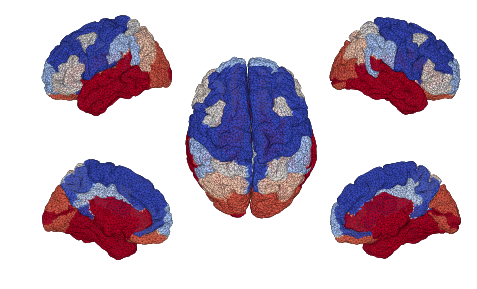

In [138]:
datvec = tvbdef_weights_mod_emb[:,1].astype(float)[tvb_rm]
plot_surface_mpl_mv(vtx=tvb_vtx,tri=tvb_tri,rm=tvb_rm,data=datvec,
                    hemi = isrh_vtx,
                    shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': -0.5, 'vmax': 0.5})

/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


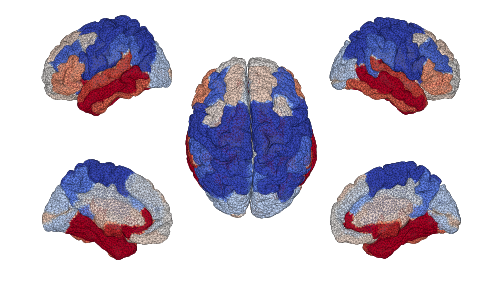

In [148]:
datvec = tvbdef_weights_mod_evecs[:,2].astype(float)[tvb_rm]*-1
plot_surface_mpl_mv(vtx=tvb_vtx,tri=tvb_tri,rm=tvb_rm,data=datvec,
                    hemi = isrh_vtx,
                    shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': -0.1, 'vmax': 0.1})

...fairly similar. esp. in terms of the dorsal/ventral split. 

So now for single hemisphere:

In [246]:
tvbdef_weights_mod_lh = tvbdef_weights_mod[tvb_conn.hemispheres==0,:][:,tvb_conn.hemispheres==0]

In [247]:
np.nonzero(tvbdef_weights_mod_lh.sum(axis=1)==0)

(array([], dtype=int64),)

In [248]:
tvbdef_weights_mod_lh_evals,tvbdef_weights_mod_lh_evecs = np.linalg.eig(tvbdef_weights_mod_lh)

In [249]:
tvbdef_weights_mod_lh_emb, tvbdef_weights_mod_lh_res = embed.compute_diffusion_map(tvbdef_weights_mod_lh, alpha = 0.5,return_result=True)

In [250]:
tvbdef_weights_lh.shape

(38, 38)

In [263]:
tvb_vtx_lh = tvb_vtx[isrh_vtx==False,:]

tvb_tri_lh = tvb_tri[(tvb_tri > tvb_vtx_lh.shape[0]).sum(axis=1),:]
#tvb_tri_lh = tvb_tri[(tvb_vtx_lh.shape[0]).sum(axis=1).astype(bool),:]

tvb_rm_lh = tvb_rm[isrh_vtx==False]

In [264]:
tvb_vtx_lh.shape

(8192, 3)

In [265]:
tvb_tri_lh.shape

(32760, 3)

In [266]:
tvb_rm_lh.shape

(8192,)

In [267]:
tvb_tri>

SyntaxError: invalid syntax (<ipython-input-267-64023131e787>, line 1)

In [268]:
tvb_tri_lh.max()

13

In [262]:
tvb_tri.max()

16383

In [243]:
tvb_tri_lh.max()

13

In [206]:
tvb_tri_lh = tvb_tri_lh - tvb_tri_lh.max()

In [207]:
tvb_tri_lh

array([[-8191, -8181, -8189],
       [-8191, -8187, -8181],
       [-8190, -8191, -8189],
       ..., 
       [    0, -6262, -6196],
       [    0, -6196, -6686],
       [    0,    -4, -6262]], dtype=int32)

In [200]:
plot_surface_mpl_mv??

In [197]:
tvb_tri_lh

array([[ 8192,  8202,  8194],
       [ 8192,  8196,  8202],
       [ 8193,  8192,  8194],
       ..., 
       [16383, 10121, 10187],
       [16383, 10187,  9697],
       [16383, 16379, 10121]], dtype=int32)

/home/hpc3230/Software/anaconda2/envs/tvb/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


IndexError: index 73 is out of bounds for axis 0 with size 39

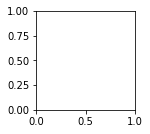

In [204]:
datvec = tvbdef_weights_mod_evecs[:,2].astype(float)[tvb_rm]*-1
plot_surface_mpl_mv(vtx=tvb_vtx,tri=tvb_tri,rm=tvb_rm,
                    hemi = isrh_vtx==False,
                    data_lh=tvbdef_weights_mod_lh_emb[:,0],
                    shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': -0.1, 'vmax': 0.1})

In [186]:
tvb_rm_lh.shape

(8192,)

In [178]:
tvb_vtx_lh = tvb_vtx[tvb_rm<=37,:]

In [180]:
plot_surface_mpl??

In [ ]:

  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

In [182]:
datvec = tvbdef_weights_mod_lh_emb[:,0].astype(float)[tvb_rm_lh]

plot_surface_mpl(vtx=tvb_vtx_lh,tri=tvb_tri,rm=tvb_rm_lh,data=datvec,view='inferior',title='inferior')


IndexError: index 8192 is out of bounds for axis 0 with size 8192

In [129]:
datvec.max()

2.8655644611091269

In [130]:
datvec.min()

-8.0068307108817045

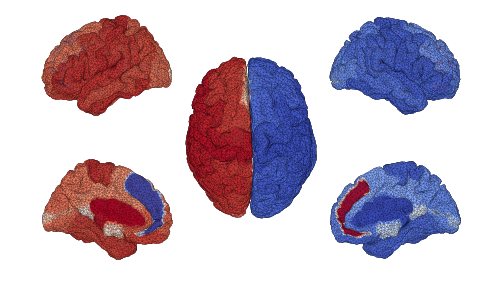

In [126]:
datvec = tvbdef_weights_mod_emb[:,0].astype(float)[tvb_rm]
plot_surface_mpl_mv(vtx=tvb_vtx,tri=tvb_tri,rm=tvb_rm,data=datvec,
                      hemi=isrh_vtx)#,title=u'rA1 \ntract length')

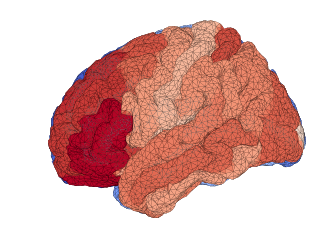

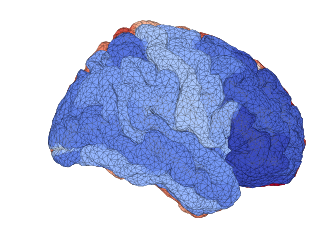

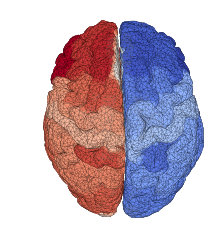

In [121]:
datvec = tvbdef_weights_evecs[:,1].astype(float)[tvb_rm]
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='lh_lat', reorient='tvb')
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='rh_lat', reorient='tvb')
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='superior', reorient='tvb')

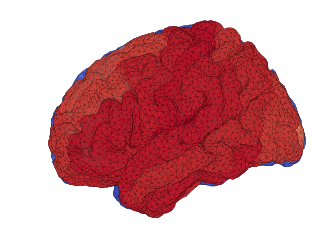

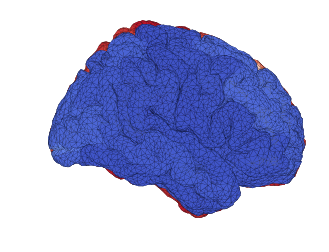

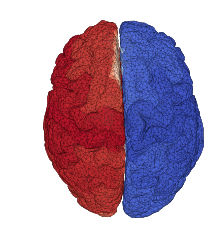

In [123]:
datvec = tvbdef_weights_mod_emb[:,0].astype(float)[tvb_rm]
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='lh_lat', reorient='tvb')
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='rh_lat', reorient='tvb')
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='superior', reorient='tvb')

In [ ]:
datvec = tvbdef_weights_mod_emb[:,1].astype(float)[tvb_rm]
plot_surface_mpl_mv(tvb_vtx,tvb_tri,datvec,view='lh_lat', reorient='tvb')
plot_surface_mpl_mv(tvb_vtx,tvb_tri,datvec,view='rh_lat', reorient='tvb')
plot_surface_mpl_mv(tvb_vtx,tvb_tri,datvec,view='superior', reorient='tvb')

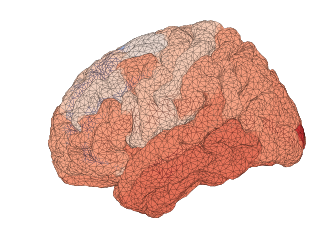

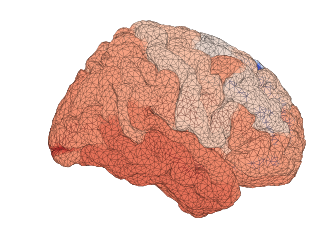

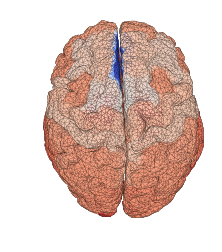

In [122]:
datvec = tvbdef_weights_mod_emb[:,1].astype(float)[tvb_rm]
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='lh_lat', reorient='tvb')
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='rh_lat', reorient='tvb')
plot_surface_mpl(tvb_vtx,tvb_tri,datvec,view='superior', reorient='tvb')

In [117]:

# Visualization stuff

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplot
import matplotlib as mpl
import matplotlib.pyplot as pyplot
import matplotlib.colors
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.tri import Triangulation
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image,display as d,clear_output
import seaborn as sns

from numpy import pi,cos,sin



In [115]:
#Visualization things - see here https://johngriffiths.github.io/LabNotebook/mpl-surface-viz.html


def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)
        
        
        
        
def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views 
   
  This function calls plot_surface_mpl five times to give a complete 
  picture of a surface- or region-based spatial pattern. 

  As with plot_surface_mpl, this function is written so as to be 
  generally usable with neuroimaging surface-based data, and does not 
  require construction of of interaction with tvb datatype objects. 

  In order for the medial surfaces to be displayed properly, it is 
  necessary to separate the left and right hemispheres. This can be 
  done in one of two ways: 

  1. Provide single arrays for vertices, faces, data, and 
     region mappings, and addition provide arrays of indices for 
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False 
     indicating left hemisphere vertices/faces/regions, and 1/True 
     indicating right hemisphere. 

     Note: this requires that 

  2. Provide separate vertices,faces,data,and region mappings for 
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)


 
  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices
 
  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) - 
      

  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``
  
  tri_lh            : left hemisphere surface faces 
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot
 
  kwargs           : additional tripcolor kwargs; see plot_surface_mpl

 

  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths 
  # connectivity matrix. The corresponding region is 
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'}) 


  """
   

 
  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])
    
  if rm_lh is not None:                                  # Option 2 
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])
    
 

  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the 
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't 
  #  connected by the faces in tri )
  
  # LH lateral
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)
    
  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)
    
  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)
    
  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)
    
  # Both superior
  plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)
    
  plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0,
                      top=1.0, wspace=0, hspace=0)    
    
    
    
    

def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat



def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''



  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])